In [35]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import datetime   # handle date times
import re

In [36]:
#df = pd.read_csv('data/US_Accidents_Dec19.csv',encoding='utf-8')
#
df = pd.read_csv('data/txDF.csv',encoding='utf-8')
df.head()

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Country,Visibility(mi),Weather_Condition,Precipitation(in),Sunrise_Sunset,Civil_Twilight
0,261007,A-261009,2,2016-11-30 16:03:54,2016-11-30 17:20:00,30.336502,-97.755646,Austin,Travis,TX,78731,US,10.0,Clear,NaN,Day,Day
1,261008,A-261010,2,2016-11-30 16:32:18,2016-11-30 17:47:02,30.328165,-97.694305,Austin,Travis,TX,78752-2826,US,10.0,Clear,NaN,Day,Day
2,261009,A-261011,2,2016-11-30 16:31:45,2016-11-30 17:46:34,30.326077,-97.692307,Austin,Travis,TX,78752,US,10.0,Clear,NaN,Day,Day
3,261010,A-261012,2,2016-11-30 16:06:49,2016-11-30 17:27:00,32.856014,-97.513084,Fort Worth,Tarrant,TX,76135,US,NaN,NaN,NaN,Day,Day
4,261011,A-261013,3,2016-11-30 16:35:01,2016-11-30 17:49:39,32.797668,-97.212090,Fort Worth,Tarrant,TX,76118,US,NaN,NaN,NaN,Day,Day


In [37]:
df.columns

Index(['Unnamed: 0', 'ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'City', 'County', 'State', 'Zipcode', 'Country',
       'Visibility(mi)', 'Weather_Condition', 'Precipitation(in)',
       'Sunrise_Sunset', 'Civil_Twilight'],
      dtype='object')

In [38]:
columns_of_interest=['ID','Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'City', 'County', 'State',
       'Zipcode', 'Country','Visibility(mi)', 'Weather_Condition','Precipitation(in)','Sunrise_Sunset','Civil_Twilight']
condition=df['State'] =='TX'
txDF=df[condition][columns_of_interest]

txDF.head()

txDF['City'].value_counts()

Houston        93245
Austin         58553
Dallas         57823
San Antonio    21613
El Paso         9352
               ...  
Pilot Point        1
Buckholts          1
Bluff Dale         1
Etoile             1
Atlanta            1
Name: City, Length: 713, dtype: int64

In [39]:
# Number of accidents that happen at Night
txDF.groupby(['Sunrise_Sunset'])['ID'].count()

Sunrise_Sunset
Day      230645
Night     67417
Name: ID, dtype: int64

In [40]:
print(len(txDF['Precipitation(in)']))
#print(len(txDF['Precipitation(in)'].dropna()))
#precipitation=txDF['Precipitation(in)'].dropna()

condition = txDF['Precipitation(in)'].notnull() & txDF['Precipitation(in)'] > 0.0
precipitation= txDF[condition]

print(len(precipitation))
print(precipitation.head())

precipitation['Precipitation(in)'].describe()

# Over 75% where there is some precipitation happen with less than 0.1 inches of rain

#precipitation.describe()


298062
14434
           ID  Severity           Start_Time             End_Time  Start_Lat  \
598  A-261607         2  2016-12-02 13:37:39  2016-12-02 14:50:57  30.230623   
599  A-261608         2  2016-12-02 13:38:31  2016-12-02 14:52:57  30.334192   
600  A-261609         3  2016-12-02 13:40:53  2016-12-02 14:55:53  30.231228   
603  A-261612         2  2016-12-02 13:59:51  2016-12-02 15:29:39  30.257950   
608  A-261617         2  2016-12-02 14:25:24  2016-12-02 15:40:08  30.233406   

     Start_Lng    City  County State     Zipcode Country  Visibility(mi)  \
598 -97.813980  Austin  Travis    TX  78745-1331      US            10.0   
599 -97.718262  Austin  Travis    TX  78752-3510      US            10.0   
600 -97.742569  Austin  Travis    TX       78741      US            10.0   
603 -97.715096  Austin  Travis    TX  78702-4759      US            10.0   
608 -97.795509  Austin  Travis    TX       78704      US            10.0   

    Weather_Condition  Precipitation(in) Sunrise_

count    14434.000000
mean         0.099047
std          0.184035
min          0.010000
25%          0.010000
50%          0.040000
75%          0.100000
max          2.940000
Name: Precipitation(in), dtype: float64

In [41]:
txDF['Weather_Condition'].value_counts()

Clear                                  76753
Mostly Cloudy                          47948
Overcast                               45135
Partly Cloudy                          37059
Scattered Clouds                       25356
                                       ...  
N/A Precipitation                          2
Rain Shower                                2
Thunderstorms and Snow                     1
Heavy Thunderstorms with Small Hail        1
Thunder and Hail / Windy                   1
Name: Weather_Condition, Length: 65, dtype: int64

In [42]:
txDF['Visibility(mi)'].value_counts()

10.00     232214
9.00       10617
7.00        8271
8.00        6966
5.00        5329
6.00        4797
4.00        4046
3.00        3943
13.00       3760
2.00        2511
2.50        1629
1.00        1444
0.20        1379
0.50         912
1.50         855
1.80         697
0.80         627
1.20         486
0.10         180
11.00        146
12.00        143
20.00        122
0.75          97
0.25          84
0.00          79
0.40          19
2.80          14
0.70          12
0.12          11
1.90           8
15.00          7
1.60           5
5.50           5
0.06           5
2.20           4
10.50          3
111.00         3
0.60           3
3.50           3
1.10           2
0.90           2
0.63           2
46.00          1
1.40           1
Name: Visibility(mi), dtype: int64

In [45]:
# code fron fast ai
# Date Feature Engineering
# will split data colum in to corresponding 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    attributes = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    #, 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in attributes:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [46]:
add_datepart(txDF,'Start_Time',False )
txDF.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)',
       'Weather_Condition', 'Precipitation(in)', 'Sunrise_Sunset',
       'Civil_Twilight', 'Start_TimeYear', 'Start_TimeMonth', 'Start_TimeWeek',
       'Start_TimeDay', 'Start_TimeDayofweek', 'Start_TimeDayofyear',
       'Start_TimeElapsed'],
      dtype='object')

In [47]:
txDF.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,...,Precipitation(in),Sunrise_Sunset,Civil_Twilight,Start_TimeYear,Start_TimeMonth,Start_TimeWeek,Start_TimeDay,Start_TimeDayofweek,Start_TimeDayofyear,Start_TimeElapsed
0,A-261009,2,2016-11-30 16:03:54,2016-11-30 17:20:00,30.336502,-97.755646,Austin,Travis,TX,78731,...,NaN,Day,Day,2016,11,48,30,2,335,1480521834
1,A-261010,2,2016-11-30 16:32:18,2016-11-30 17:47:02,30.328165,-97.694305,Austin,Travis,TX,78752-2826,...,NaN,Day,Day,2016,11,48,30,2,335,1480523538
2,A-261011,2,2016-11-30 16:31:45,2016-11-30 17:46:34,30.326077,-97.692307,Austin,Travis,TX,78752,...,NaN,Day,Day,2016,11,48,30,2,335,1480523505
3,A-261012,2,2016-11-30 16:06:49,2016-11-30 17:27:00,32.856014,-97.513084,Fort Worth,Tarrant,TX,76135,...,NaN,Day,Day,2016,11,48,30,2,335,1480522009
4,A-261013,3,2016-11-30 16:35:01,2016-11-30 17:49:39,32.797668,-97.212090,Fort Worth,Tarrant,TX,76118,...,NaN,Day,Day,2016,11,48,30,2,335,1480523701


In [31]:
def dow(df):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return days[df]
    

txDF['Start_TimeDayofweek'] =txDF['Start_TimeDayofweek'].apply(dow)


In [32]:
txDF['Start_TimeDayofweek'].head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: Start_TimeDayofweek, dtype: object

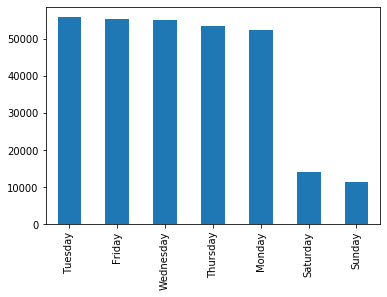

In [33]:
txDF['Start_TimeDayofweek'].value_counts().plot(kind='bar',y=dayOfWeek)

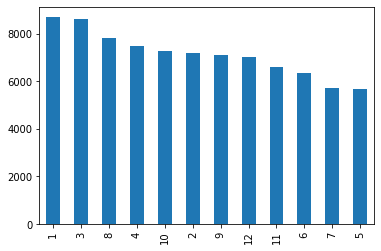

In [55]:
condition = txDF['Start_TimeYear'] == 2017

txDF[condition]['Start_TimeMonth'].value_counts().plot(kind='bar',y=dayOfWeek)
